The following example shows how to train a model. Get a list of training data csv file in the selected folder. Lessons learned so far:
- Training result is very sensitive to normalization. The normalization approach based on mean and variance does not work very well. Still need to manually set mean and variance.
- t-sne plot of adapter trace is an important flag of training result. 
- h net does not have to descent because phi net training strives to make it rise, while h net training itself tries to lower the loss
- Increase the h training frequency to fight against rising h 
- Increase alpha to push domain info to adapter
- Increase number of features to minimize MSE loss.
- ocassional small spike in cross entropy loss is possibly a sign that phi net become further domain invariant and may not be bad.
- at the late stage of training while both mse loss and cross entropy loss converge. May need to train h net every step to refine the optimization direction.
- Do not need to select the model at the end epoch. Select the epoch when the loss is reasonably low and stable. 
- RMS is a good indicator because it matches the least square form of loss function
- When the residual force is small, e.g. training disturbance force compensated by BEMT, disturbance normalization should scale up the label for better learning. 

Existing problem:
- The more classes, the harder to train. The difficulty comes from instability of loss_f and loss_c. alpha is hard to tune.
- t-sne gets worse as epoch grows and the cross entropy loss remains the same. 

In [1]:
import os
import matplotlib.pyplot as plt

import training_manager

current_dir = os.getcwd()
# training_subfolder = "wind_near_wall_wo_bemt_in_control_train_x_only_wind"
# training_subfolder = "wind_near_wall_wo_bemt_in_control_train_z_only_wind"
training_subfolder = "wind_near_wall_wo_bemt_in_control_train_xz_wind"
# training_subfolder = "nf_training_back2back"
# validation_subfolder = "nf_validation_back2back"
validation_subfolder = "wind_near_wall_validation_no_bemt"

def generate_data_list(subfolder):
    """
    Generate a list of data files in the specified subfolder.
    """
    folder_path = os.path.join(os.path.dirname(current_dir), "data", "training", subfolder)
    file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # Filter out files that do not end with .csv
    file_names = [f for f in file_names if f.endswith('.csv')]
    # add subfolder to the file names
    data_list = [os.path.join(subfolder, f) for f in file_names]
    return data_list

data_list = generate_data_list(training_subfolder)
print("Training Data List:")
for data in data_list:
    print(data)

validation_list = generate_data_list(validation_subfolder)
print("\nValidation Data List:")
for data in validation_list:
    print(data)

path1 = os.path.join(training_subfolder, "input_label_map_disturbance_force_label.yaml")

Training Data List:
wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_x0_0_y0_0_z0_0_d0_5_train_no_bemt.csv
wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_x0_0_y0_0_z5_0_d0_5_train_no_bemt.csv
wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_x0_0_y0_0_zn5_0_d0_5_train_no_bemt.csv
wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_xn3_0_y0_0_z0_0_d0_5_train_no_bemt.csv
wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_xn3_0_y0_0_z5_0_d0_5_train_no_bemt.csv
wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_xn3_0_y0_0_zn5_0_d0_5_train_no_bemt.csv

Validation Data List:
wind_near_wall_validation_no_bemt\test_wind_near_wall_x0_0_y0_0_z10_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_x0_0_y0_0_z1_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_x0_0_y0_0_z4_0_d0_5_validation_no_bemt.csv
wind_near_wall_validatio

- Make sure the input_label_map_disturbance_force_label.yaml is in the selected folder. This yaml defines which fields are model inputs and which fields are data labels. 
- Make sure the column_map.yaml is in the selected folder. This yaml maps data fields to the corresponding column in the csv files. This file can be auto-generated by `Simulation\simulation\training_data_user_guide.ipynb`
- If this is the first time to train on this data. The script will normalize the data and save the normalization parameters into a file.

Setting up data factory...
Loading normalization params file from
..\data\training\wind_near_wall_wo_bemt_in_control_train_xz_wind\normalization_params.yaml
Using 6001 samples from the dataset for training from source file: wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_x0_0_y0_0_z0_0_d0_5_train_no_bemt.csv
Using 6001 samples from the dataset for training from source file: wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_x0_0_y0_0_z5_0_d0_5_train_no_bemt.csv
Using 6001 samples from the dataset for training from source file: wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_x0_0_y0_0_zn5_0_d0_5_train_no_bemt.csv
Using 6001 samples from the dataset for training from source file: wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_xn3_0_y0_0_z0_0_d0_5_train_no_bemt.csv
Using 6001 samples from the dataset for training from source file: wind_near_wall_wo_bemt_in_control_train_xz_wind\test_wind_near_wall_xn3_0_y0_0_z5_

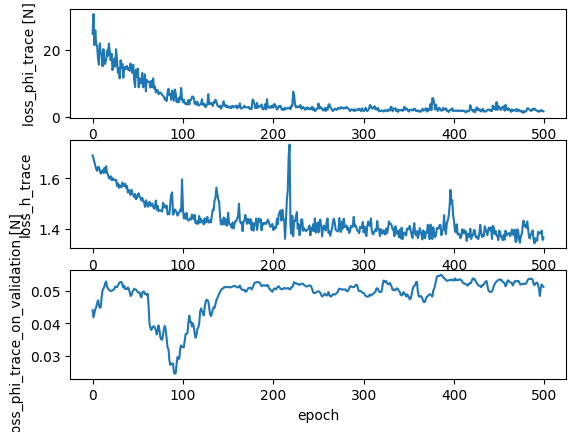

In [2]:
# use the data from previous section to train the model

factory = training_manager.PipelineFactory(True)
manager = factory.make_training_pipeline()
manager.set_up(
    training_data_menu=data_list,
    # training_data_menu=data_list[:4],    # use small data list for quick testing
    validation_data_menu=validation_list[-1:],
    input_label_map_file=path1,
    can_inspect_data=False
)
plt.show() 
manager.train()

plt.show()  

Inspect data in the data list.

Plotting t-SNE of a_trace...


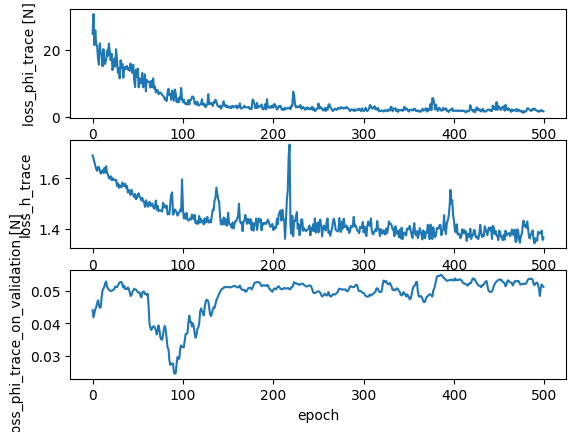

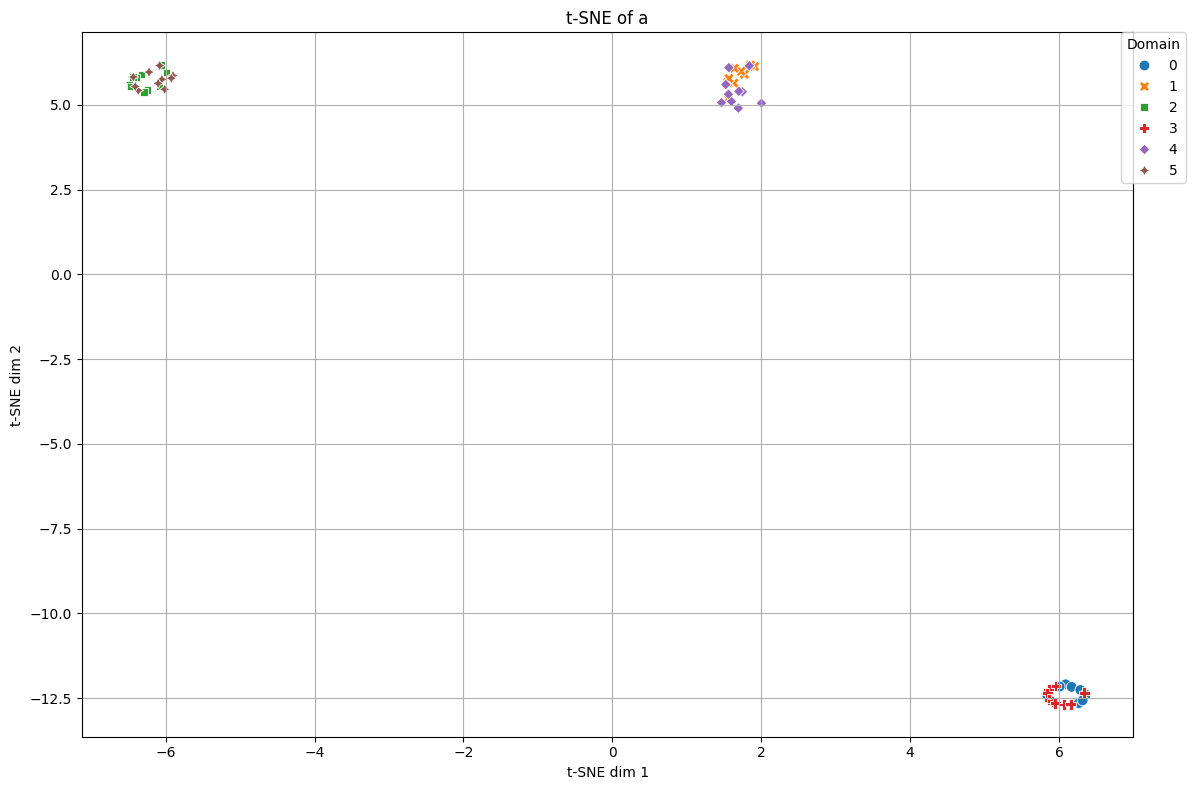

In [3]:
# trainer_instance.inspect_data(data_list[:2])
manager.show_result_only()

After training, we can save the model in the following way.

In [4]:
model_name = training_subfolder
manager.save_model(model_name)

Model saved to model\wind_near_wall_wo_bemt_in_control_train_xz_wind.pth


Test the model using the test set.

test Data List:
wind_near_wall_validation_no_bemt\test_wind_near_wall_x0_0_y0_0_z10_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_x0_0_y0_0_z1_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_x0_0_y0_0_z4_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_x0_0_y0_0_zn10_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_x0_0_y0_0_zn1_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_x0_0_y0_0_zn4_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_xn2_0_y0_0_z10_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_xn2_0_y0_0_z1_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_xn2_0_y0_0_z4_0_d0_5_validation_no_bemt.csv
wind_near_wall_validation_no_bemt\test_wind_near_wall_xn2_0_y0_0_zn10_0_d0_5_validation_no_bemt.csv
wi

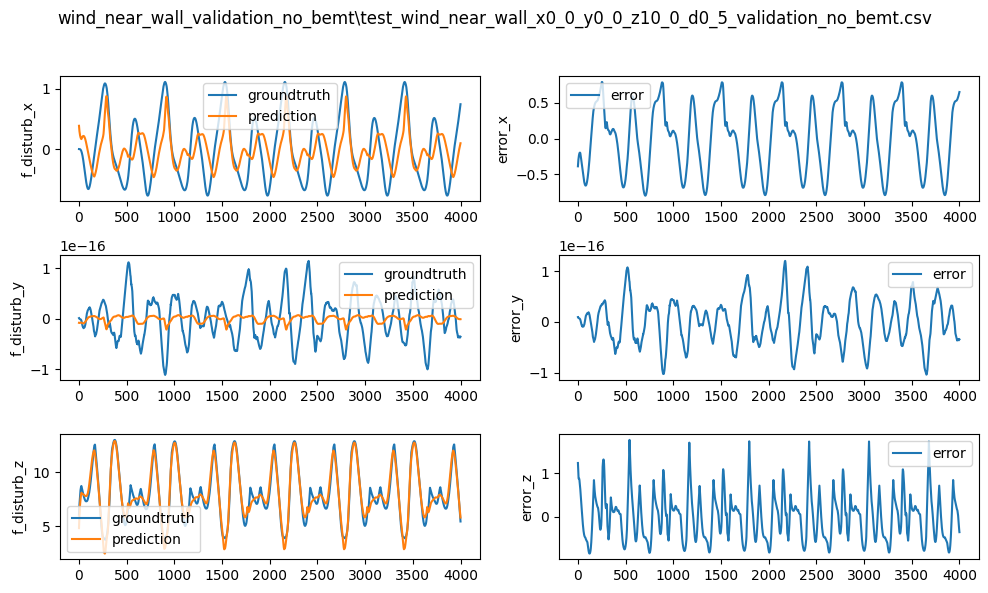

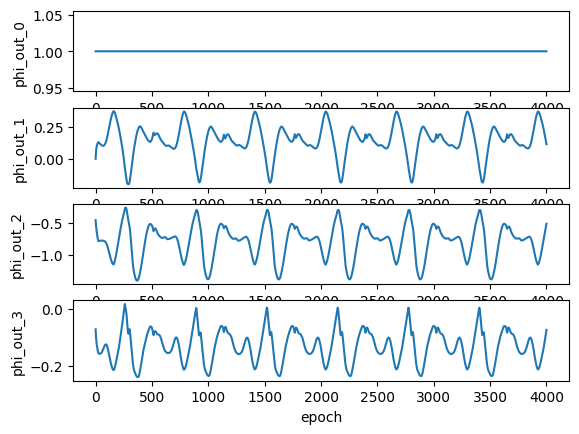

phi_out: tensor([[ 1.0000,  0.0040, -0.4621, -0.0713],
        [ 1.0000,  0.0079, -0.4682, -0.0732],
        [ 1.0000,  0.0114, -0.4732, -0.0750],
        ...,
        [ 1.0000, -0.0957, -0.2273,  0.0150],
        [ 1.0000, -0.0993, -0.2289,  0.0114],
        [ 1.0000, -0.1027, -0.2305,  0.0079]])
a = tensor([[-2.4211e-01,  1.4163e-18, -1.6203e+00],
        [-1.3819e+00,  3.5323e-18, -1.8623e+00],
        [-2.9742e-01,  2.8555e-18, -5.7651e+00],
        [-1.4363e+00,  1.4262e-18,  6.8798e+00]])


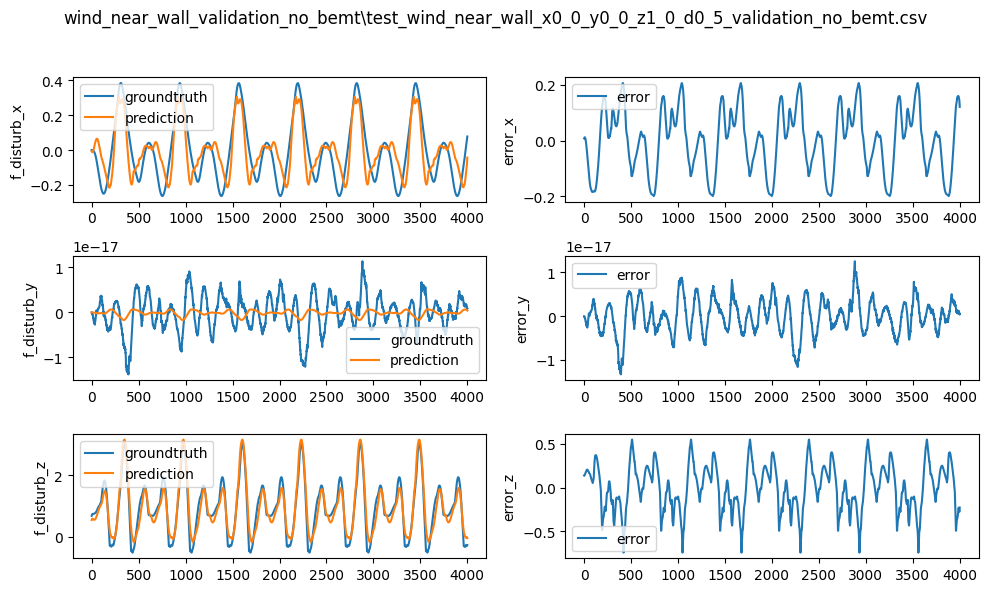

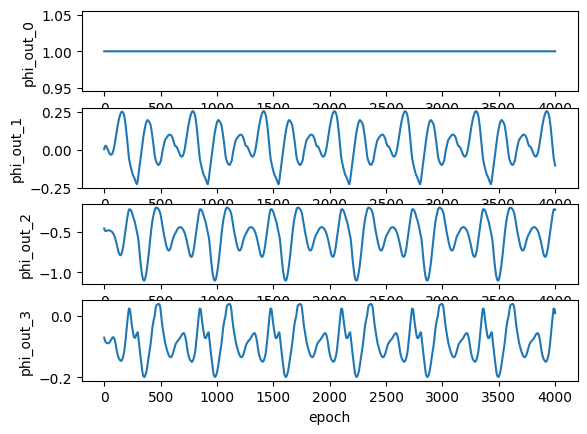

phi_out: tensor([[ 1.0000,  0.0038, -0.4624, -0.0713],
        [ 1.0000,  0.0102, -0.4726, -0.0745],
        [ 1.0000,  0.0160, -0.4814, -0.0774],
        ...,
        [ 1.0000, -0.0901, -0.2197,  0.0283],
        [ 1.0000, -0.0940, -0.2201,  0.0277],
        [ 1.0000, -0.0978, -0.2205,  0.0270]])
a = tensor([[-1.2927e-01, -1.1473e-18, -1.0969e+00],
        [-1.7232e+00, -2.9031e-18, -1.7935e+00],
        [ 4.4361e-03, -7.1996e-18, -1.1236e+01],
        [-2.5388e+00,  3.3329e-17,  2.6598e+01]])


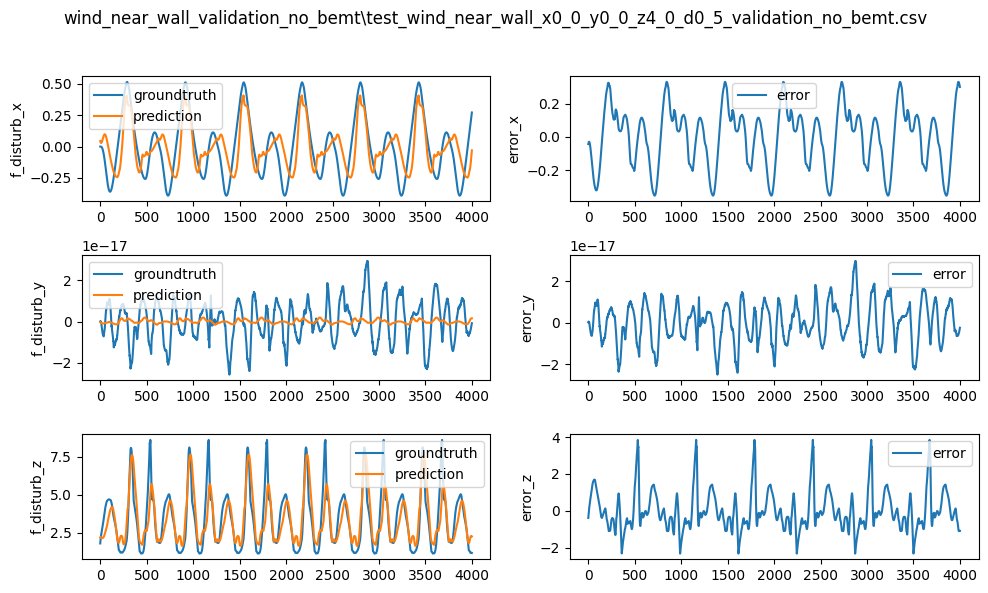

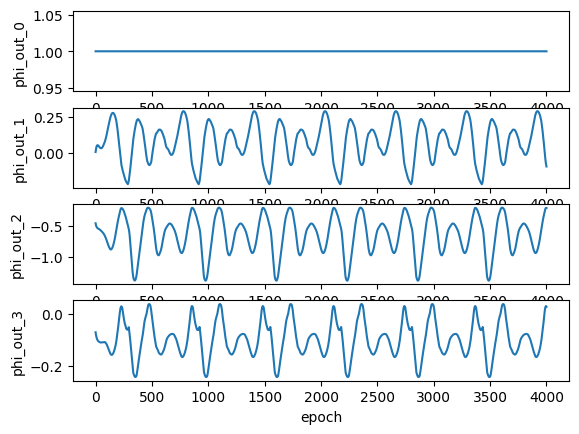

phi_out: tensor([[ 1.0000,  0.0035, -0.4628, -0.0713],
        [ 1.0000,  0.0131, -0.4782, -0.0761],
        [ 1.0000,  0.0216, -0.4912, -0.0803],
        ...,
        [ 1.0000, -0.0201, -0.3048, -0.0068],
        [ 1.0000, -0.0271, -0.3000, -0.0047],
        [ 1.0000, -0.0338, -0.2957, -0.0030]])
a = tensor([[-1.1501e+00,  4.8629e-18,  3.6245e+00],
        [-1.4844e+00,  4.1232e-17,  5.0736e+00],
        [-3.0978e+00,  3.9382e-17,  1.5009e+00],
        [ 6.9132e+00, -1.7092e-16,  1.1693e+00]])


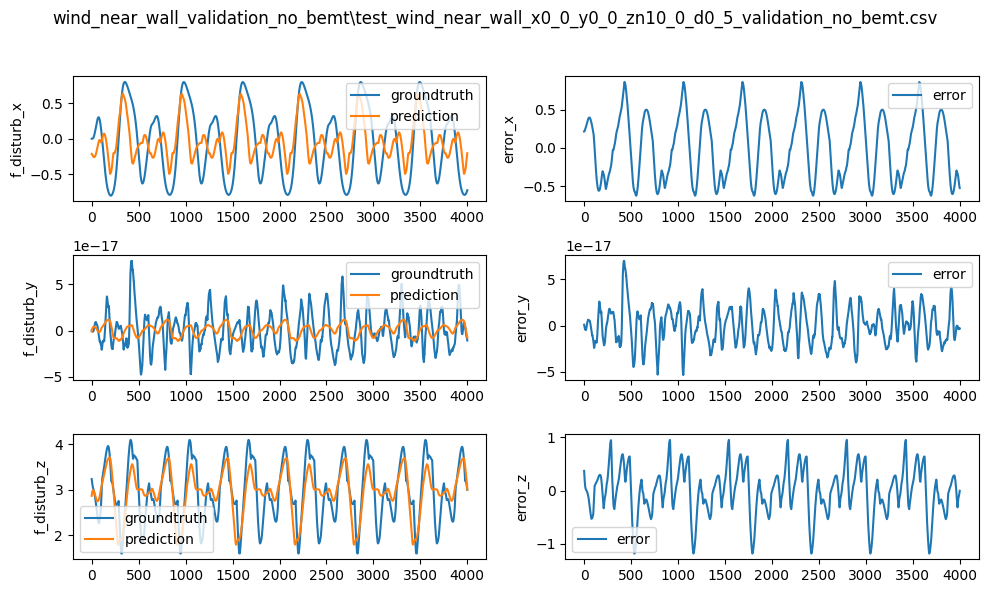

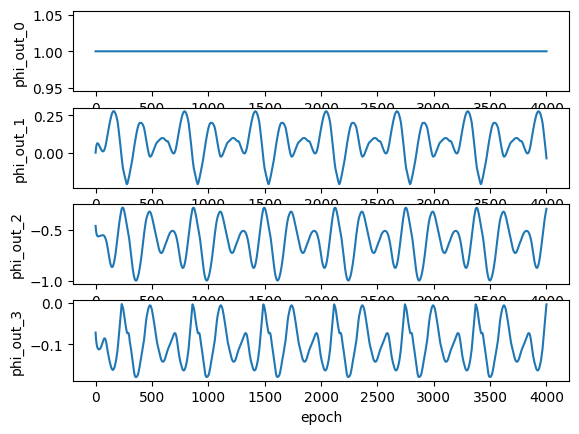

phi_out: tensor([[ 1.0000,  0.0043, -0.4618, -0.0713],
        [ 1.0000,  0.0053, -0.4631, -0.0718],
        [ 1.0000,  0.0062, -0.4640, -0.0723],
        ...,
        [ 1.0000, -0.0963, -0.2354,  0.0122],
        [ 1.0000, -0.0999, -0.2364,  0.0093],
        [ 1.0000, -0.1031, -0.2379,  0.0061]])
a = tensor([[-3.1822e-01, -1.2969e-18, -2.2354e+00],
        [-1.2230e+00, -2.8814e-18, -2.2408e+00],
        [-5.4968e-01, -5.6008e-18, -5.6039e+00],
        [-5.9656e-01,  2.2343e-17,  1.0634e+01]])


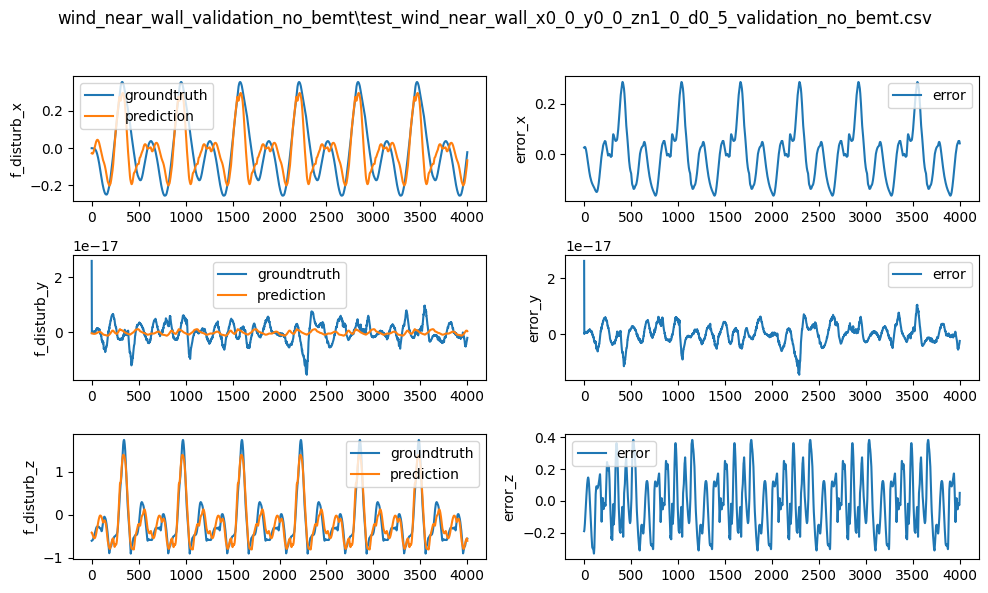

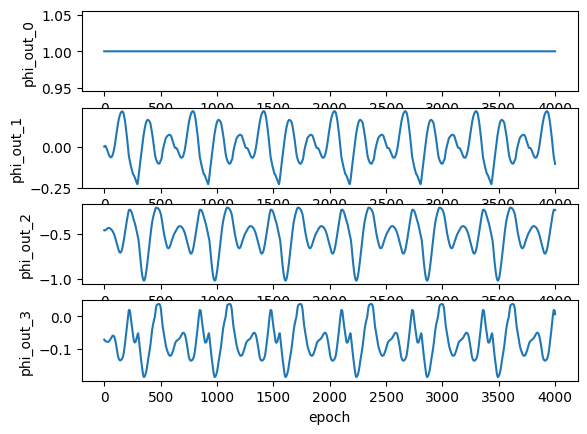

phi_out: tensor([[ 1.0000,  0.0042, -0.4618, -0.0713],
        [ 1.0000,  0.0057, -0.4640, -0.0720],
        [ 1.0000,  0.0071, -0.4656, -0.0727],
        ...,
        [ 1.0000, -0.0868, -0.2422,  0.0139],
        [ 1.0000, -0.0903, -0.2424,  0.0133],
        [ 1.0000, -0.0940, -0.2433,  0.0121]])
a = tensor([[-5.8466e-01, -3.1066e-18,  1.7252e-01],
        [-1.3298e+00,  2.6939e-18,  1.1557e+00],
        [-1.3185e+00, -1.5533e-17,  7.9822e-01],
        [ 1.1739e+00,  6.6856e-17,  7.9000e-01]])


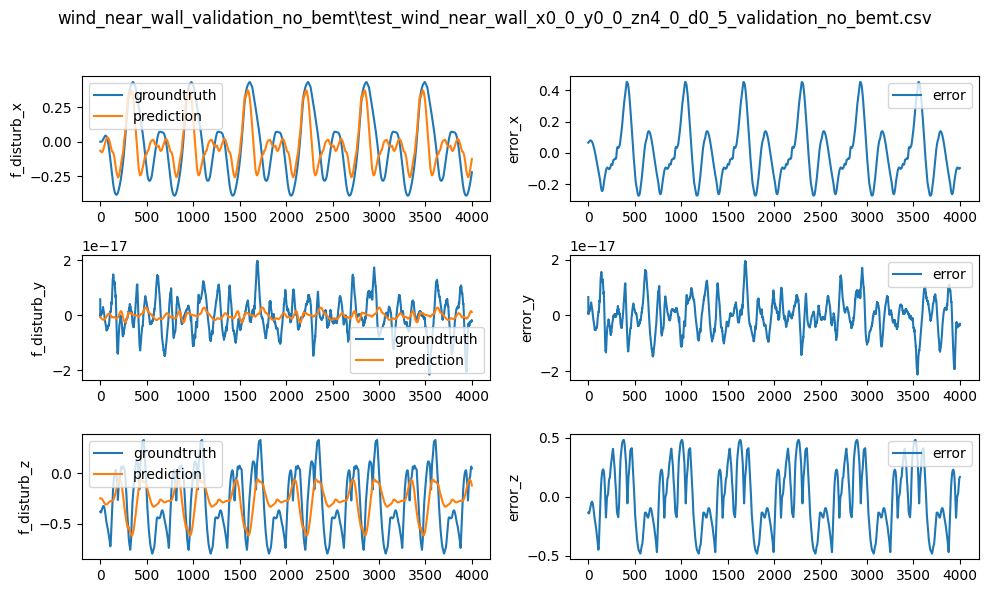

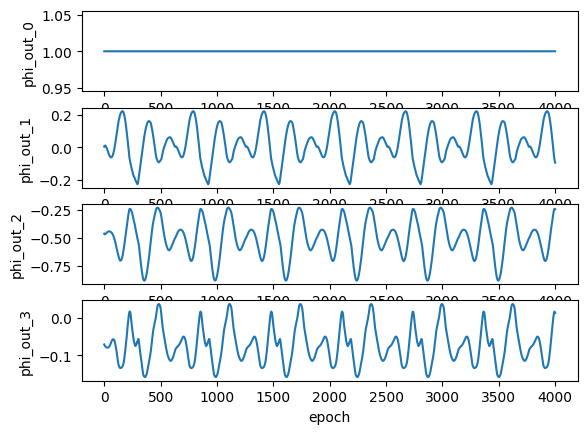

phi_out: tensor([[ 1.0000,  0.0030, -0.4633, -0.0712],
        [ 1.0000,  0.0189, -0.4867, -0.0790],
        [ 1.0000,  0.0330, -0.5075, -0.0859],
        ...,
        [ 1.0000,  0.1153, -0.5605, -0.0845],
        [ 1.0000,  0.1108, -0.5534, -0.0824],
        [ 1.0000,  0.1063, -0.5466, -0.0803]])
a = tensor([[ 1.4254e-01, -1.3838e-16,  1.3281e+00],
        [-2.4506e+00,  2.5831e-17,  5.3371e+00],
        [ 5.8970e-01,  6.8096e-17, -6.7983e+00],
        [-3.6767e+00, -1.2626e-15, -3.2615e+00]])


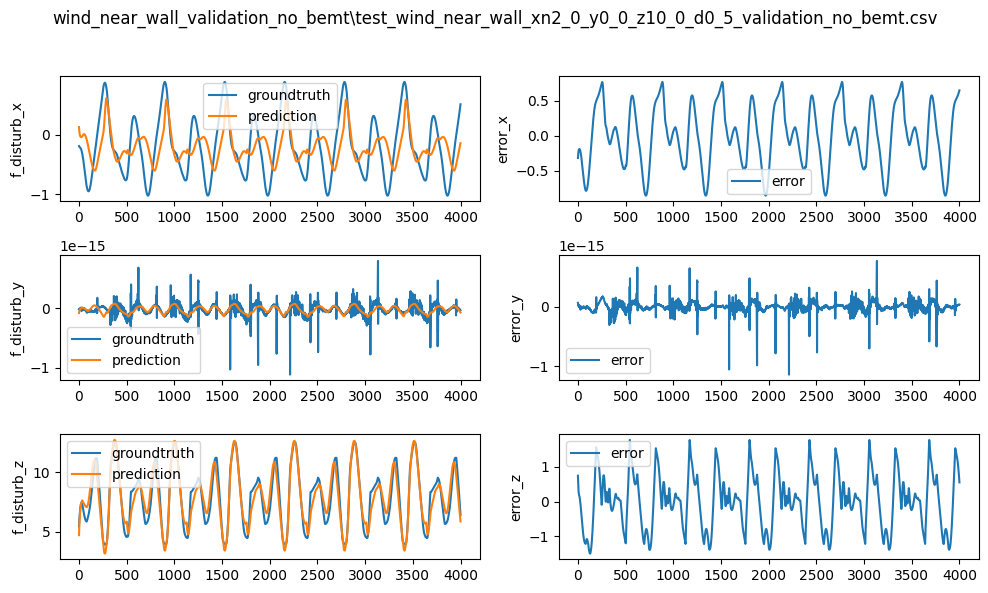

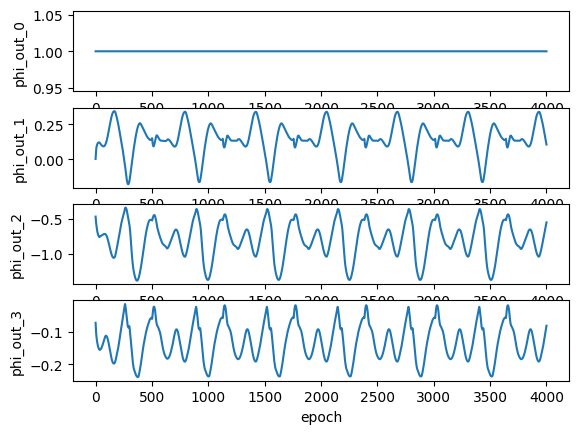

phi_out: tensor([[ 1.0000,  0.0040, -0.4620, -0.0712],
        [ 1.0000,  0.0090, -0.4683, -0.0737],
        [ 1.0000,  0.0133, -0.4736, -0.0758],
        ...,
        [ 1.0000, -0.0863, -0.2302,  0.0187],
        [ 1.0000, -0.0900, -0.2305,  0.0181],
        [ 1.0000, -0.0940, -0.2314,  0.0169]])
a = tensor([[-3.8221e-01, -1.0963e-17, -1.1095e+00],
        [-1.3953e+00,  1.0689e-17, -7.2649e-01],
        [-3.6058e-01, -8.1127e-18, -4.8350e+00],
        [-7.8838e-01,  6.1280e-17,  5.5632e+00]])


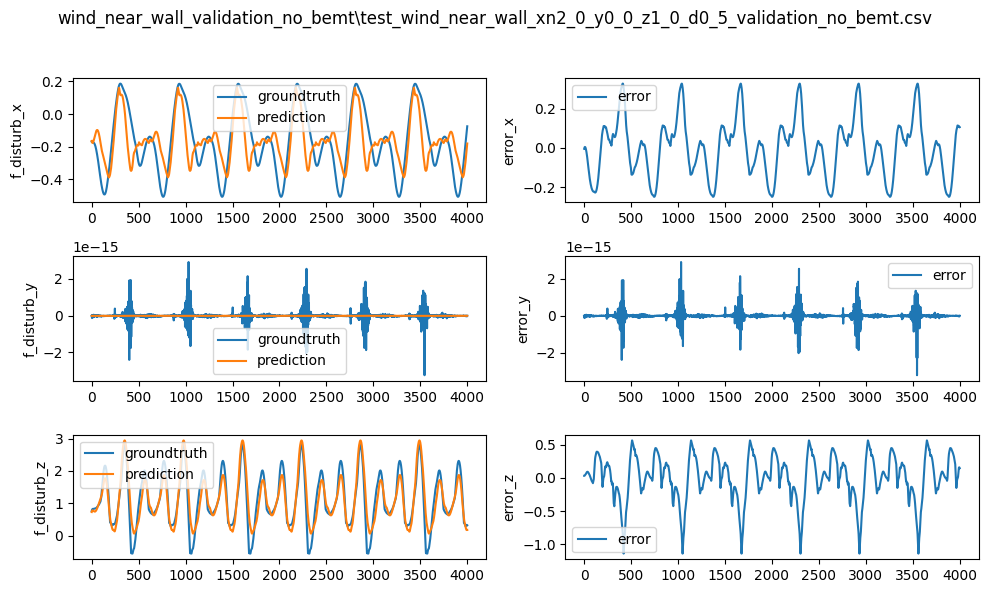

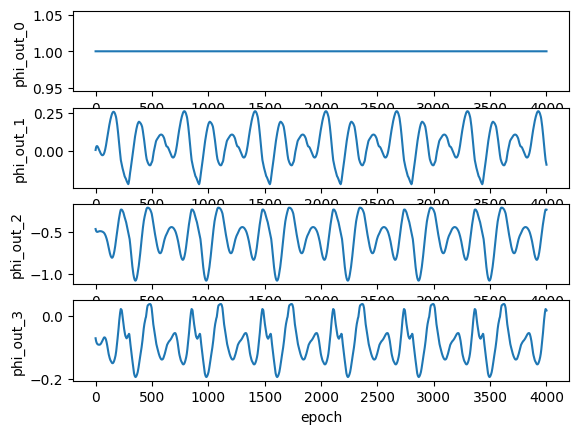

phi_out: tensor([[ 1.0000,  0.0035, -0.4627, -0.0713],
        [ 1.0000,  0.0133, -0.4769, -0.0761],
        [ 1.0000,  0.0217, -0.4891, -0.0803],
        ...,
        [ 1.0000, -0.0790, -0.2224,  0.0270],
        [ 1.0000, -0.0828, -0.2224,  0.0264],
        [ 1.0000, -0.0865, -0.2226,  0.0257]])
a = tensor([[-3.4319e-01, -2.2641e-17, -6.3093e-01],
        [-1.7090e+00, -2.4020e-17, -3.5558e+00],
        [-2.2118e-01, -1.6183e-17, -8.8796e+00],
        [-1.4269e+00,  4.7926e-17,  1.4415e+01]])


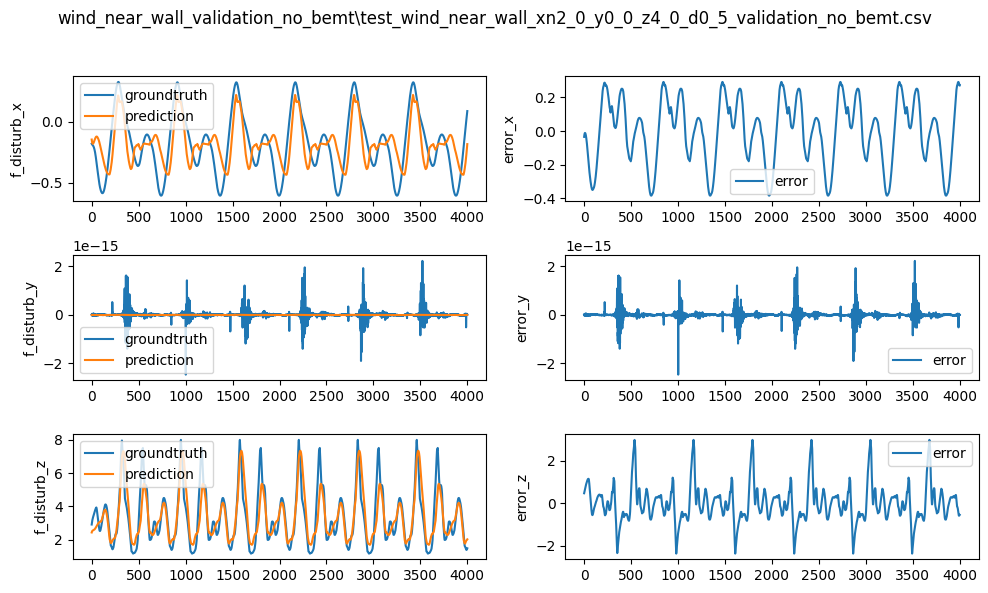

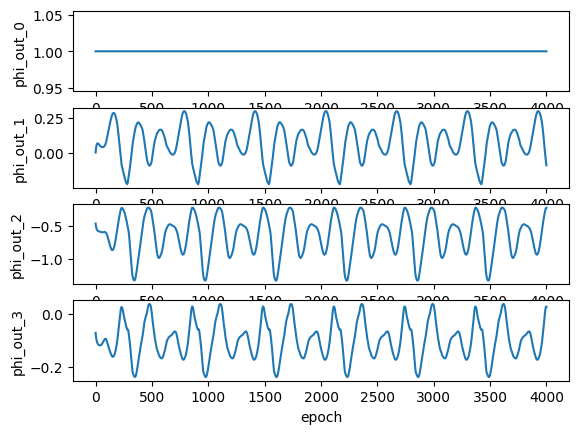

phi_out: tensor([[ 1.0000,  0.0035, -0.4626, -0.0712],
        [ 1.0000,  0.0141, -0.4768, -0.0763],
        [ 1.0000,  0.0229, -0.4889, -0.0806],
        ...,
        [ 1.0000, -0.0275, -0.3016, -0.0081],
        [ 1.0000, -0.0343, -0.2979, -0.0071],
        [ 1.0000, -0.0409, -0.2959, -0.0077]])
a = tensor([[-1.5218e+00, -1.3407e-17,  3.1885e+00],
        [-1.3136e+00, -4.7713e-17,  5.2488e+00],
        [-3.9364e+00,  1.6824e-17, -7.8873e-02],
        [ 1.0674e+01, -8.4102e-17,  7.0285e+00]])


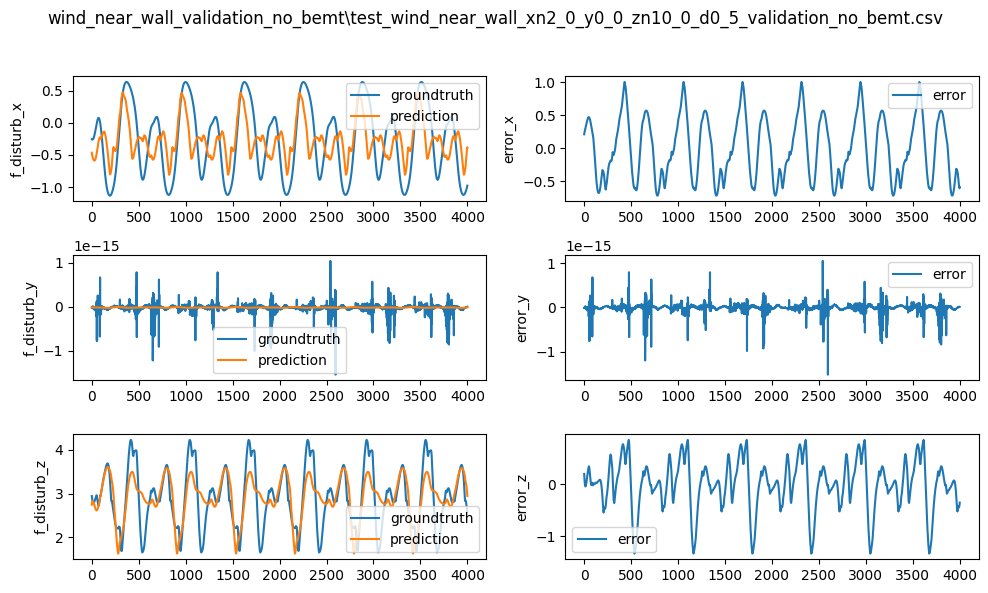

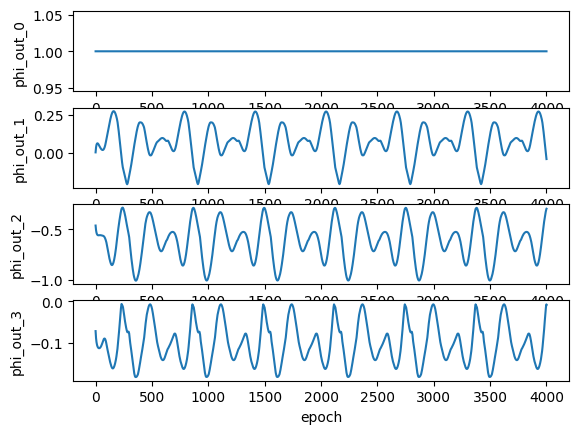

phi_out: tensor([[ 1.0000,  0.0042, -0.4617, -0.0712],
        [ 1.0000,  0.0064, -0.4632, -0.0722],
        [ 1.0000,  0.0081, -0.4643, -0.0731],
        ...,
        [ 1.0000, -0.0928, -0.2373,  0.0103],
        [ 1.0000, -0.0964, -0.2383,  0.0075],
        [ 1.0000, -0.0999, -0.2399,  0.0040]])
a = tensor([[-4.6164e-01, -1.7430e-18, -1.8594e+00],
        [-1.2175e+00, -9.7923e-19, -1.2538e+00],
        [-6.2579e-01,  4.0919e-17, -4.7683e+00],
        [ 7.4111e-03, -1.2130e-16,  8.8793e+00]])


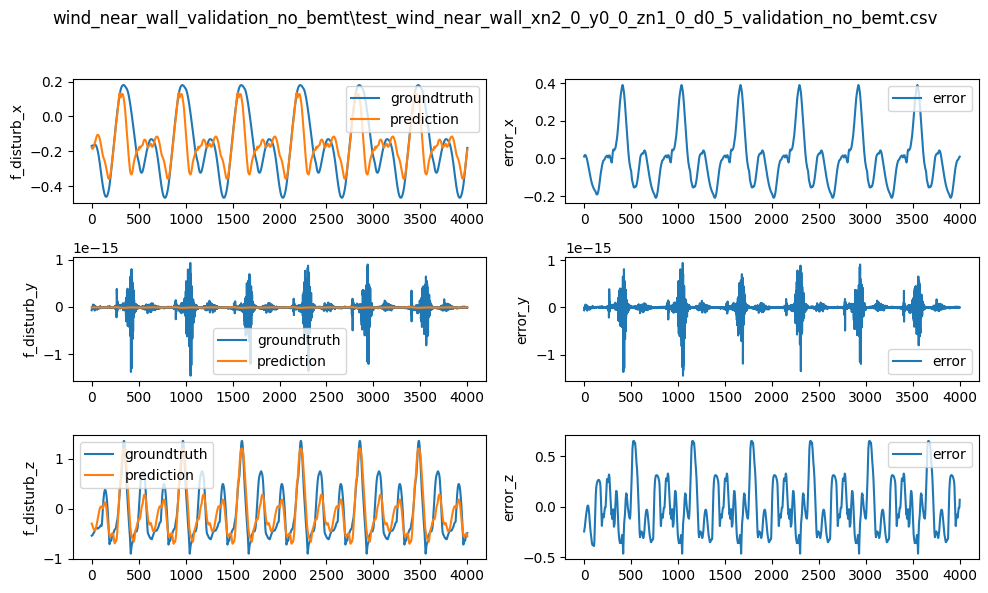

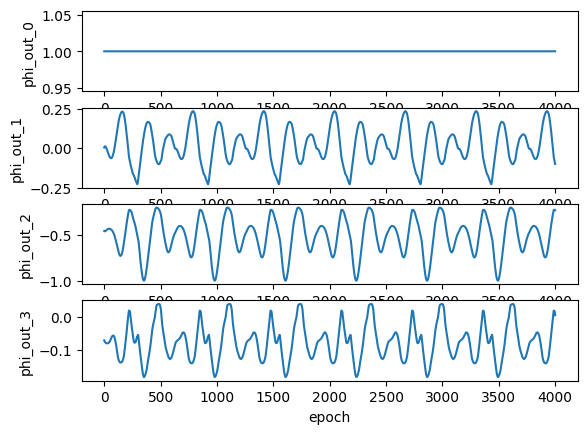

phi_out: tensor([[ 1.0000,  0.0042, -0.4617, -0.0712],
        [ 1.0000,  0.0069, -0.4636, -0.0724],
        [ 1.0000,  0.0090, -0.4651, -0.0735],
        ...,
        [ 1.0000, -0.0866, -0.2460,  0.0101],
        [ 1.0000, -0.0904, -0.2470,  0.0087],
        [ 1.0000, -0.0941, -0.2483,  0.0070]])
a = tensor([[-8.2981e-01, -1.1737e-17, -2.3271e-02],
        [-1.3494e+00, -1.5181e-17,  1.3368e+00],
        [-1.6651e+00,  1.1197e-17,  2.0670e-01],
        [ 2.6126e+00, -1.2851e-17,  2.7397e+00]])


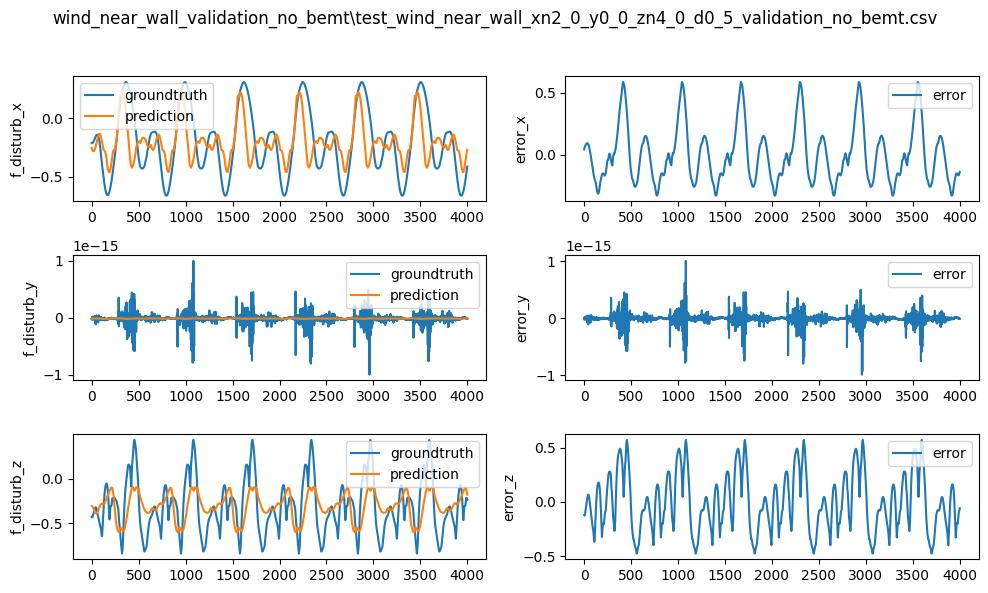

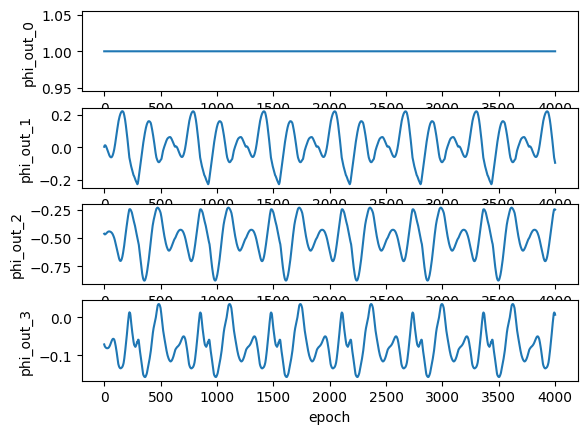

phi_out: tensor([[ 1.0000,  0.0031, -0.4629, -0.0711],
        [ 1.0000,  0.0195, -0.4841, -0.0789],
        [ 1.0000,  0.0336, -0.5029, -0.0858],
        ...,
        [ 1.0000,  0.1114, -0.5503, -0.0824],
        [ 1.0000,  0.1066, -0.5444, -0.0804],
        [ 1.0000,  0.1018, -0.5386, -0.0785]])
a = tensor([[-5.5859e-01, -2.1596e-16,  1.4801e+00],
        [-2.5558e+00,  6.9382e-18,  2.9502e+00],
        [-4.9321e-01, -1.1155e-16, -9.8741e+00],
        [-1.7693e-01, -5.1181e-16,  1.5624e+01]])


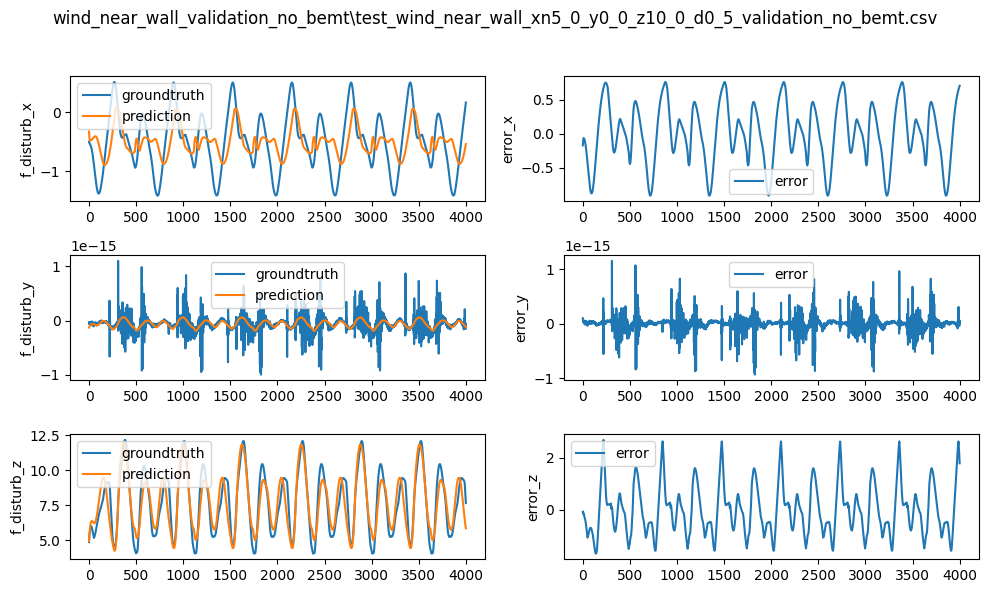

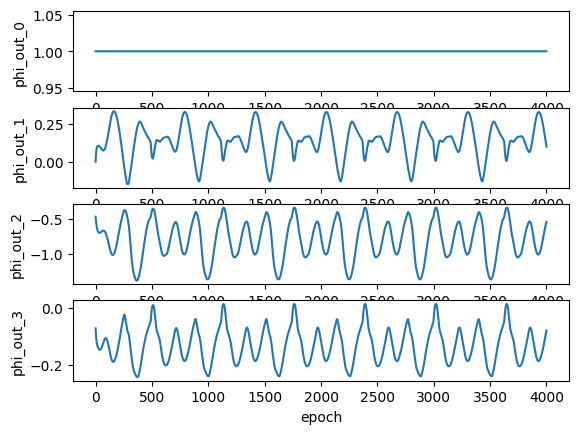

phi_out: tensor([[ 1.0000,  0.0039, -0.4620, -0.0711],
        [ 1.0000,  0.0112, -0.4694, -0.0746],
        [ 1.0000,  0.0172, -0.4758, -0.0775],
        ...,
        [ 1.0000, -0.0727, -0.2407,  0.0155],
        [ 1.0000, -0.0765, -0.2392,  0.0162],
        [ 1.0000, -0.0802, -0.2390,  0.0158]])
a = tensor([[-6.3024e-01,  3.5148e-17, -3.5685e-01],
        [-1.4924e+00,  2.7611e-17,  5.4117e-01],
        [-5.6310e-01,  1.8528e-16, -3.4224e+00],
        [ 5.4192e-01, -2.7664e-16,  2.1646e+00]])


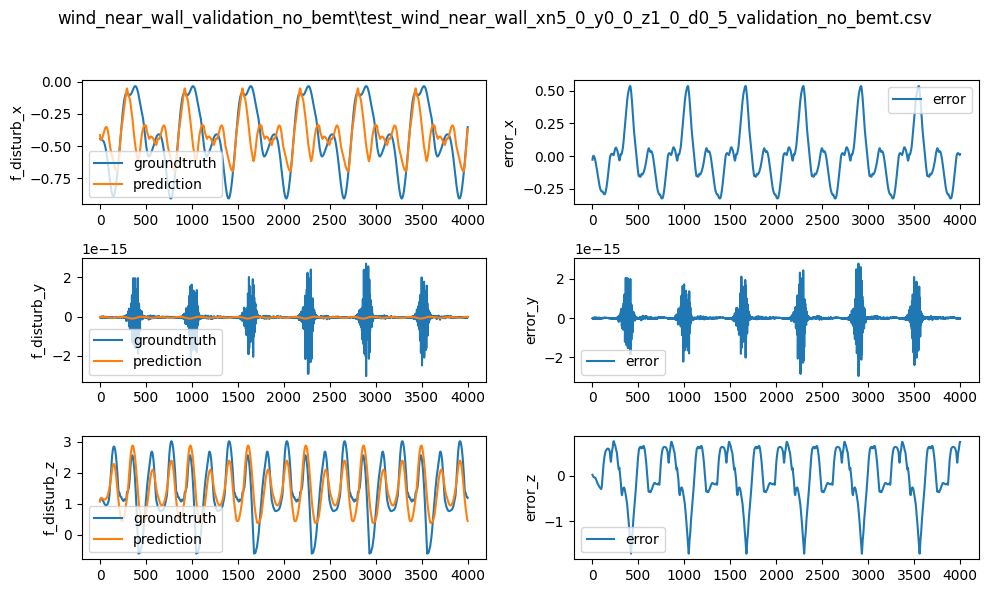

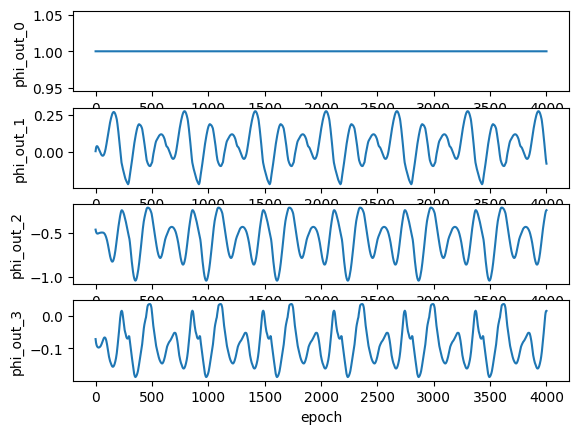

phi_out: tensor([[ 1.0000,  0.0035, -0.4621, -0.0710],
        [ 1.0000,  0.0150, -0.4747, -0.0763],
        [ 1.0000,  0.0246, -0.4857, -0.0809],
        ...,
        [ 1.0000, -0.0158, -0.2913,  0.0023],
        [ 1.0000, -0.0224, -0.2869,  0.0045],
        [ 1.0000, -0.0288, -0.2827,  0.0066]])
a = tensor([[-5.8621e-01, -4.1782e-17, -8.1014e-02],
        [-1.7982e+00, -2.9546e-17, -5.8663e+00],
        [-3.0471e-01, -6.6533e-18, -8.6034e+00],
        [-6.8551e-01,  4.0396e-17,  1.2120e+01]])


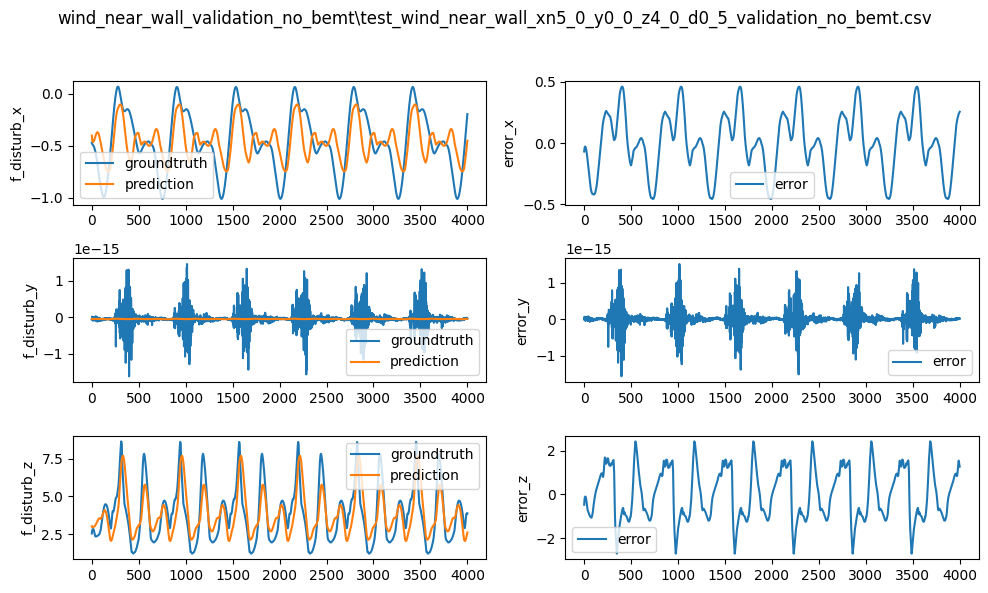

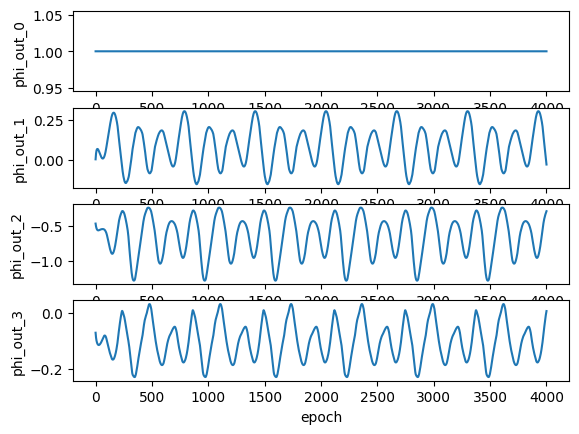

phi_out: tensor([[ 1.0000,  0.0035, -0.4623, -0.0710],
        [ 1.0000,  0.0160, -0.4758, -0.0769],
        [ 1.0000,  0.0261, -0.4874, -0.0818],
        ...,
        [ 1.0000, -0.0517, -0.2840, -0.0082],
        [ 1.0000, -0.0580, -0.2818, -0.0080],
        [ 1.0000, -0.0642, -0.2799, -0.0079]])
a = tensor([[-1.9478e+00, -3.8168e-17,  1.9518e+00],
        [-1.0837e+00, -2.5999e-17,  5.7329e+00],
        [-4.8469e+00,  7.9468e-18, -3.9208e+00],
        [ 1.5309e+01,  7.6183e-17,  1.9860e+01]])


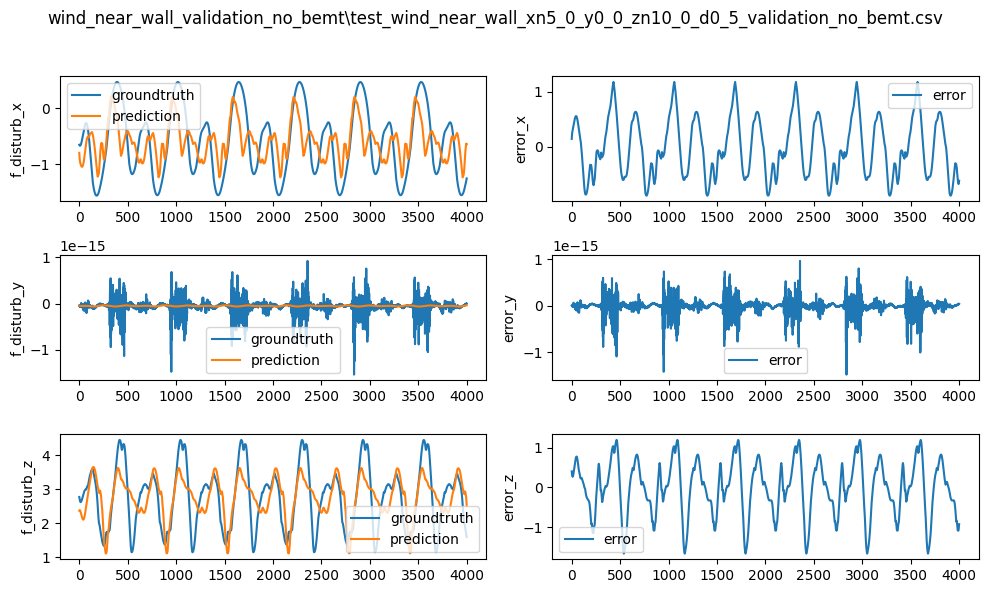

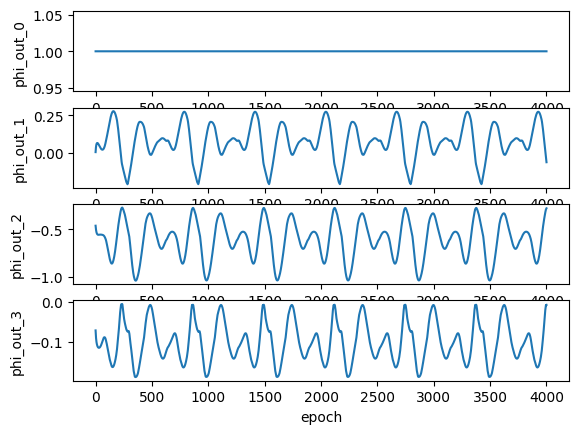

phi_out: tensor([[ 1.0000,  0.0041, -0.4617, -0.0711],
        [ 1.0000,  0.0084, -0.4647, -0.0731],
        [ 1.0000,  0.0118, -0.4671, -0.0748],
        ...,
        [ 1.0000, -0.0784, -0.2422,  0.0129],
        [ 1.0000, -0.0819, -0.2424,  0.0123],
        [ 1.0000, -0.0855, -0.2428,  0.0116]])
a = tensor([[-6.5641e-01, -1.0809e-17, -8.0097e-01],
        [-1.2902e+00,  2.7352e-18,  1.7585e-01],
        [-6.8977e-01,  8.8122e-17, -2.6317e+00],
        [ 8.7852e-01, -2.4057e-16,  3.4266e+00]])


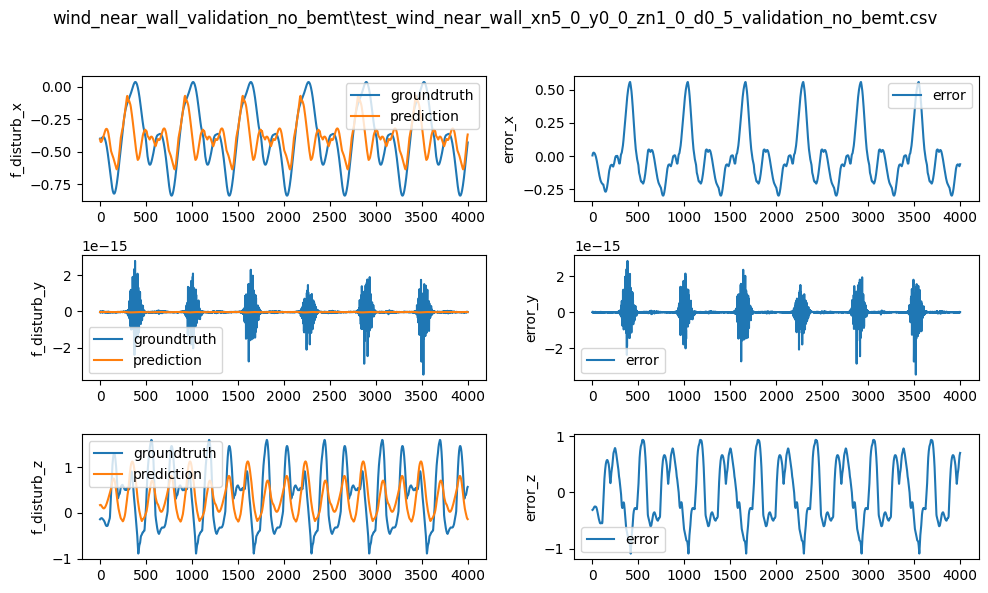

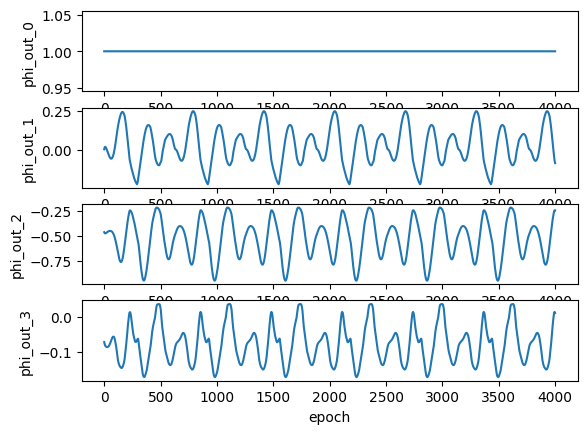

phi_out: tensor([[ 1.0000,  0.0042, -0.4614, -0.0710],
        [ 1.0000,  0.0088, -0.4632, -0.0731],
        [ 1.0000,  0.0121, -0.4646, -0.0747],
        ...,
        [ 1.0000, -0.0855, -0.2507,  0.0056],
        [ 1.0000, -0.0891, -0.2520,  0.0040],
        [ 1.0000, -0.0927, -0.2531,  0.0017]])
a = tensor([[-1.0822e+00, -1.0797e-16, -1.4946e-01],
        [-1.2518e+00, -9.5438e-17,  1.4398e+00],
        [-1.9123e+00, -1.7560e-16, -4.6225e-01],
        [ 4.1588e+00,  2.2732e-16,  4.9476e+00]])


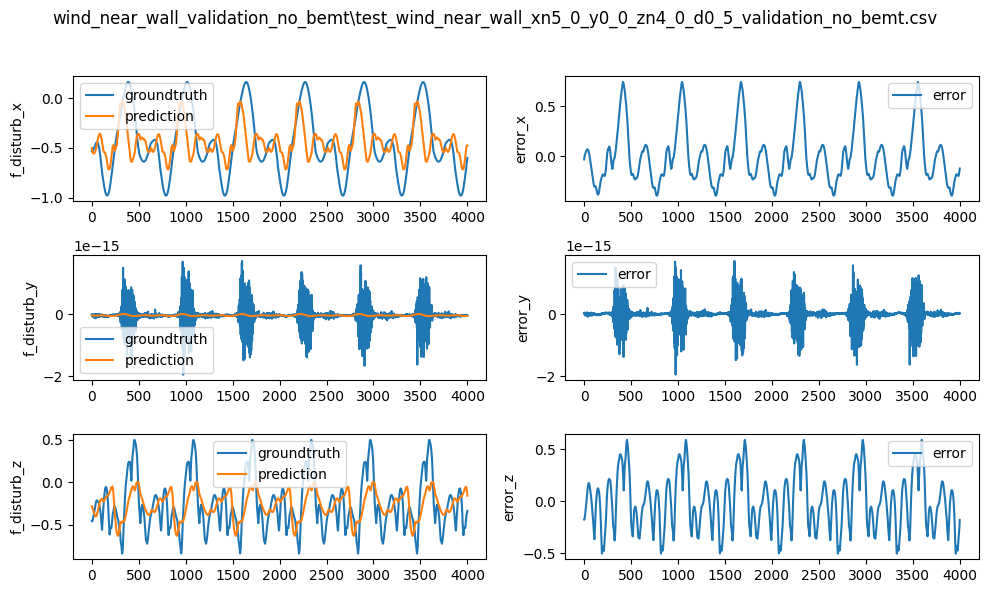

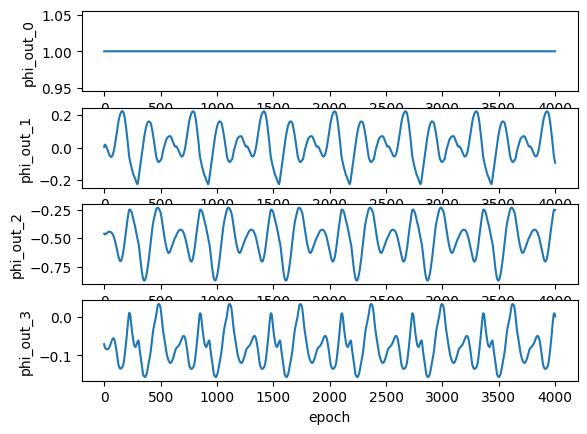

average rms for dim 0: 0.27942372114285047
average rms for dim 1: 1.3511911859735815e-16
average rms for dim 2: 0.5553453542877324


c:\YimingVirtualDDrive\7_workSpace\repo\neural-fly\Simulation\learning\validator.py:153: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


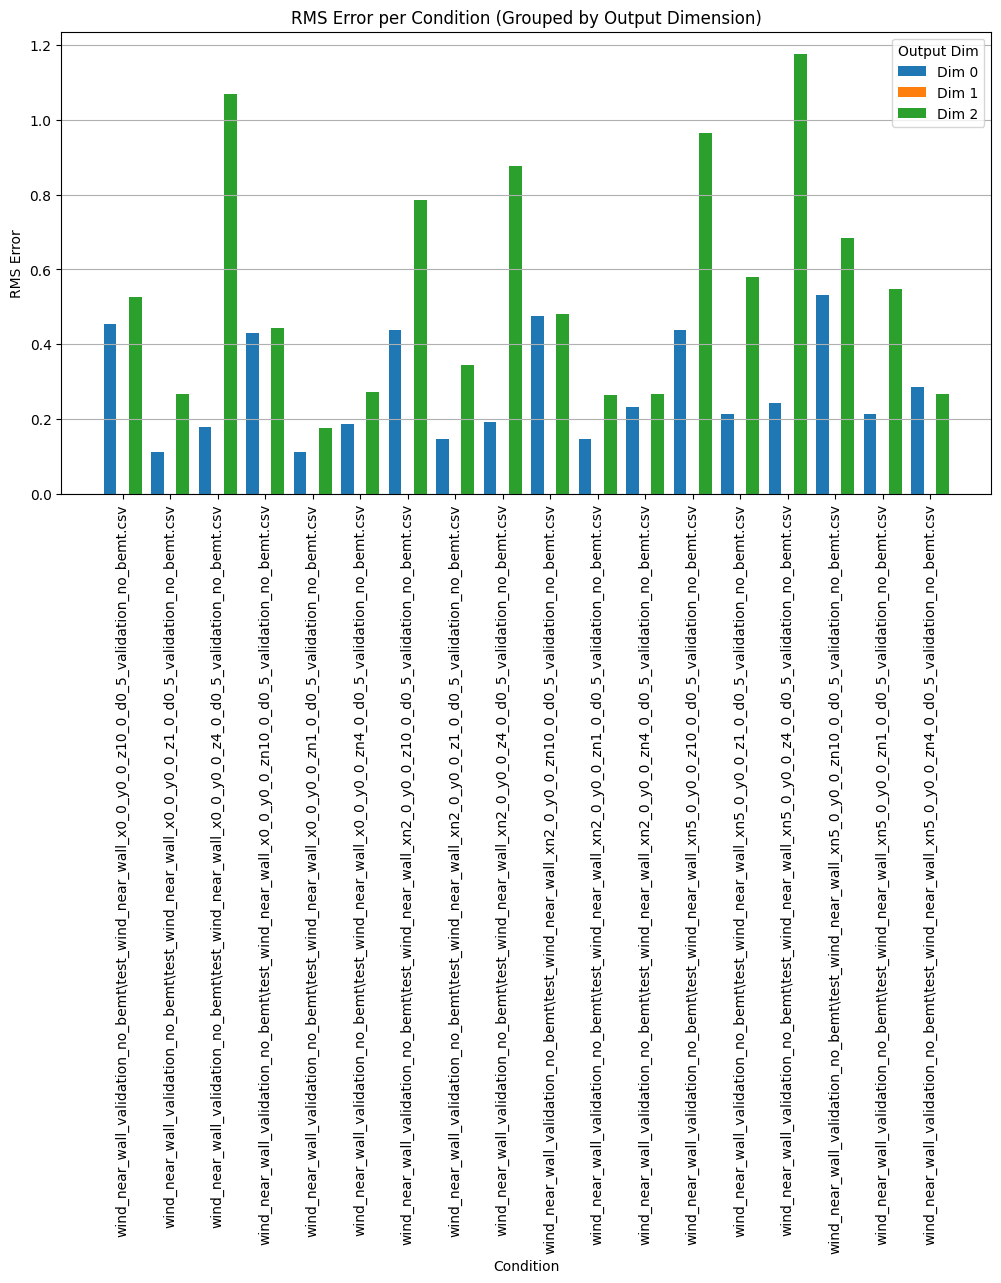

average mse for dim 0: 0.09675282406236242
average mse for dim 1: 3.1416422512232124e-32
average mse for dim 2: 0.3981085714932103


c:\YimingVirtualDDrive\7_workSpace\repo\neural-fly\Simulation\learning\validator.py:192: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


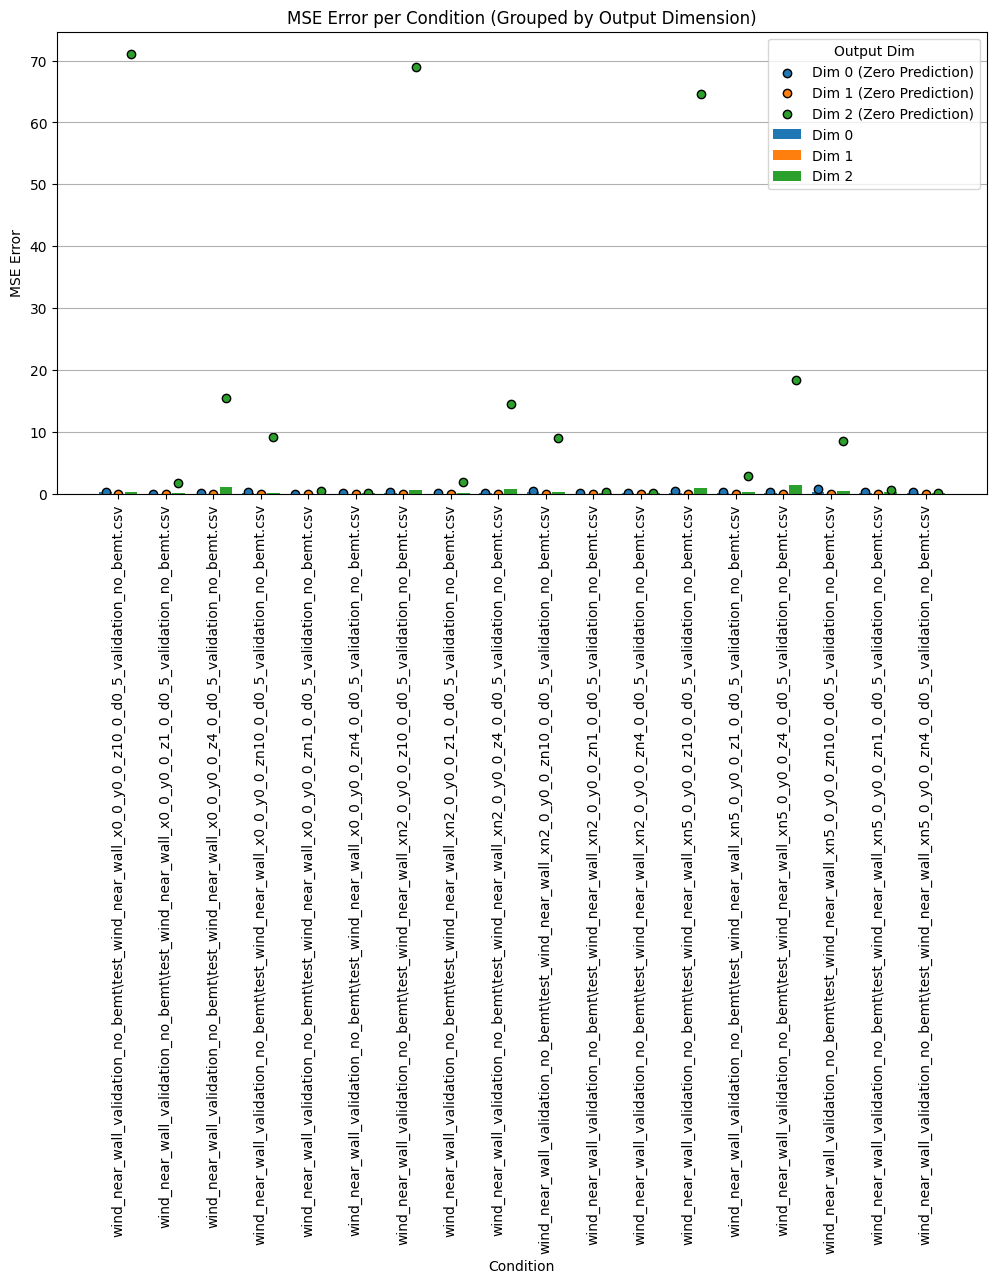

In [5]:
%matplotlib inline
model_name = training_subfolder

# subfolder = "wind_near_wall_validation_bemt"
subfolder = "wind_near_wall_validation_no_bemt"
# subfolder = "nf_validation_back2back"
data_list = generate_data_list(subfolder)
print("test Data List:")
for data in data_list:
    print(data)

# debug
# data_list = data_list[:1]  # use small data list for quick testing

manager = factory.make_test_pipeline()

manager.set_up(
    data_menu=data_list,
    input_label_map_file=path1,
    model_name=model_name
)

# make a new trainer to replicate the above setup, just to allow verify_model to work
manager.test()
plt.show()  
